# GARCH Delta-Hedging vs Black-Scholes Delta Hedging

In this notebook we will fit various GARCH(p, q) models to stock price data obtained using Yahoo Finance. We will use this data to create synthetic call options and then simulate trading them while applying delta-hedging strategies.

Delta-hedging is used to neutralize the risk that comes from changes in the underlying stock’s price. This is achieved by strategically buying or selling the underlying stock so that the overall sensitivity of the portfolio (options + stock) with respect to the stock price—its delta—is close to zero. In this setup, the volatility of the underlying stock becomes the key factor to predict, making the choice of volatility model central to the performance of the hedging strategy.

The two models that we will be exploring in this notebook are Black-Scholes and GARCH(p, q) for various values of p and q. Black–Scholes assumes constant volatility over the life of the option. This makes the math elegant and tractable, but does not reflect real markets very well. Actual stock returns exhibit volatility clustering, meaning periods of high volatility tend to follow each other. The same is true for low volatility. This is where GARCH models comes into play. GARCH models treat volatility varying with time, which is much more accurate to the reality of the market. GARCH models then attempt to predict the volatility of the next day's stock path based on past returns. Instead of a single constant, GARCH produces a volatility forecast for each period that adapts to market conditions.

The goal of this project is to compare the hedging effectiveness of Black–Scholes and GARCH-based delta-hedging strategies. We will measure performance by examining hedging errors, turnover, and sensitivity to volatility assumptions. This comparison highlights how assumptions about volatility impact real-world trading strategies, which is a central challenge in quantitative finance.

We will begin by defining the functions being used to instatiate the models, create the synthetic call options and perform the delta-hedging. We then will walk through the usage of these functions to create the DataFrame, and then will visualize the results for analytical purposes.

In [37]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from arch import arch_model
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

# The Functions

The function bs_call_delta is the Black-Scholes function that will use to calculate our delta. Delta is the change in option value with respect to the change in stock price: $\Delta=\frac{\partial V}{\partial S}$. Therefore, if you want your portfolio to be as $\Delta$-neutral as possible, you must purchase $N\cdot\Delta$ many stocks where $N$ is the number of options contracts you are currently holding.

In [38]:
def bs_call_delta(S0, K, sigma, t, r):
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*t) / (sigma*np.sqrt(t))
    return norm.cdf(d1)

def bs_call(S0, K, sigma, t, r):
    '''
    Black-Scholes Call Option formula
    
    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate
    
    
    Return:
    Black-Scholes value of call option (float)
    '''
    
    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    call_value = S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    return call_value

ExecModel is our execution model, meaning that it takes a target number of hedge shares and simulates what would actually happen if we were to place that order in the market. The goal with this class was to be as close to realistic as possible. This requires including the following inputs:

- commission_per_share: broker fee per share traded
- spread_bps: width of the bid-ask spread in basis points
- extra_slip_bps: extra slippage, also in bps, to simulate impact or imperfect fills
- min_trade_shares: Minimum trading size that we are willing to execute. This is so that we avoid trades that are so small that they are practically meaningless
- hysteresis: requires the target position to be different enough from the current position before trading. This prevents us from making lots of back-and-forth trades when the delta oscillates slightly around the target.

In [39]:
class ExecModel:
    def __init__(self, commission_per_share=0.005, spread_bps=1.0, extra_slip_bps=0.0, min_trade_shares=1, hysteresis_shares=5):
        self.comm = commission_per_share
        self.spread_bps = spread_bps
        self.slip_bps = extra_slip_bps
        self.min_trade = min_trade_shares
        self.hysteresis = hysteresis_shares

    def _bid_ask(self, mid):
        # creates an artificial bid-ask spread around the midpoint price
        spread = mid * (self.spread_bps / 1e4)  # basis points to fraction
        bid = mid - spread/2
        ask = mid + spread/2
        return bid, ask

    def fill(self, current_shares, target_shares, mid_price):
        delta_shares = int(np.round(target_shares)) - int(current_shares)
        
        if abs(delta_shares) < max(self.hysteresis, self.min_trade):
            return 0, 0.0, 0.0  # no trade, no cash change, no fees

        bid, ask = self._bid_ask(mid_price)
        slip = mid_price * (self.slip_bps / 1e4)

        if delta_shares > 0:  # buying
            fill_px = ask + slip
        else:                 # selling
            fill_px = bid - slip

        trade_shares = delta_shares
        cash_change = -fill_px * trade_shares  # negative when buying, positive when selling
        fees = self.comm * abs(trade_shares)
        return trade_shares, cash_change, fees

The following code block directly predicts the next day's volatility using the previous data. We predict the volatility in two different ways.

In RollingBSVol we calculate the volatility in the standard Black-Scholes way, by calculating the annualized standard deviation of the log-returns from a rollling window of historical data. Later in the code we will vary the length of this rolling window in order to have multiple Black-Scholes-based delta-hedging strategies to compare against our GARCH models.

RollingGARCHVol is a bit more sophisticated. In RollingGARCHVol we begin by initializing the necessary information needed for an accurate GARCH prediction. We begin with the p and q values that are plugged into GARCH(p, q). The value p is the number of lagged variances that our model will be taking into account. This is used to capture the long-term persistence in volatility. The value q is the number of lagged squared shocks, meaning the number of past squared returns we will use to explain today’s volatility. This is used to capture the short-term reaction of volatility to new information.

In [40]:
class RollingBSVol:
    def __init__(self, window=63, trading_days=252):
        self.window = window
        self.annual = trading_days

    def sigma_at(self, logret_series, t_idx):
        # Annualized rolling std using data up to t-1. t_idx is the integer representing the day that we are at in the backtest.

        up_to = logret_series.iloc[:t_idx].tail(self.window) # computes the time series of daily log returns up to previous day
        if len(up_to) < max(10, self.window//3):  # need minimum data
            return np.nan
        return up_to.std() * np.sqrt(self.annual)

class RollingGARCHVol:
    def __init__(self, p=1, q=1, refit_every=5, lookback=504, trading_days=252):
        self.p, self.q = p, q # GARCH(p,q) parameters
        self.refit_every = refit_every # How often to refit the model
        self.lookback = lookback # How far back the training data goes
        self.annual = trading_days # For annualizing volatility
        self._last_fit_day = None # Keeps track of which day the model was last fit
        self._last_params = None # Keeps track of the parameters from the previous fitting

    def _fit(self, logrets): # Fits the model
        am = arch_model(logrets*100, vol='GARCH', p=self.p, q=self.q, dist='normal') # logrets*100 so that input is in percentages, not decimals
        res = am.fit(disp="off") # outputs are suppressed for cleanliness
        return res

    def sigma_at(self, logret_series, t_idx):
        # Forecasts next-day vol using data up to t-1. Refit every refit_every days on last 'lookback' returns.

        if t_idx < 2: # note enough data to work with
            return np.nan
        
        # choose sample window
        end = t_idx
        start = max(0, end - self.lookback)
        sample = logret_series.iloc[start:end]

        # make sure we have enough lags to get a meaningful fit
        if len(sample) < max(50, self.p + self.q + 10):
            return np.nan

        # Check whether it is time to refit or not
        if (self._last_fit_day is None) or ((t_idx - self._last_fit_day) >= self.refit_every):
            res = self._fit(sample)
            self._last_params = res
            self._last_fit_day = t_idx
        else:
            res = self._last_params

        # One-step ahead forecast for day t (based on info through t-1)
        f = res.forecast(horizon=1, reindex=False)
        # variance for the last point in sample
        sigma_next = np.sqrt(f.variance.values[-1, 0]) / 100.0
        return sigma_next * np.sqrt(self.annual) # annualize the volatility because this is what Black-Scholes expects

The function hedge_one_lifecycle simulates trading one synthetic call option contract from its start date until its maturity, using daily delta-hedging along the way. Each day we keep track of the number of shares bought/sold, the amount of cash lost/received from trading the shares, the cumulative fees that accrued from trading and the net asset value. Once the option has expired we cash out the option and any remaining shares of underlying stock. The most relevant information from the overall liffecycle of the option is recorded in a summary dictionary associated with that option for easier access down the line, thought the day-by-day data is also kept for further analysis as well.

In [66]:
def hedge_one_lifecycle(
    px,                         # Series of close prices
    open_px,                    # Series of next-day open prices
    logrets,                    # Series of log returns aligned to px
    start_idx, maturity_days,
    strike_mult=1.0,            # ITM, ATM or OTM
    r=0.0,                      
    vol_model=None,             # volatility model (BS window or GARCH)
    exec_model=None,            # ExecModel
    contract_multiplier=100,    # shares per option
    max_inventory=1000          # cap on shares
):
    N = len(px)
    expiry_idx = start_idx + maturity_days
    if expiry_idx >= N:
        return None  # not enough future data

    # Initialize option
    S0 = float(px.iloc[start_idx])
    K = S0 * strike_mult
    T = maturity_days / 252.0

    # === Premium at inception, using the same vol model as hedge ===
    sigma0 = vol_model.sigma_at(logrets, start_idx+1)
    if np.isnan(sigma0) or sigma0 <= 0:
        return None  # can't price option at inception
    
    premium = bs_call(S0, K, sigma0, T, r) * 1.0
    cash = premium   # we are short the option, collect premium up front

    # State
    shares = 0
    fees = 0.0
    turnover = 0
    records = []

    # daily loop for hedging
    for t in range(start_idx + 1, expiry_idx + 1):
        ttm = max(1e-6, (expiry_idx - t) / 252.0)
        sigma = vol_model.sigma_at(logrets, t)

        if not (np.isnan(sigma) or sigma <= 0):
            S_t = float(px.iloc[t-1])
            delta = bs_call_delta(S_t, K, sigma, ttm, r)
            target_shares = np.clip(delta * contract_multiplier,
                                    -max_inventory, max_inventory)

            mid = float(open_px.iloc[t]) if t < len(open_px) else float(px.iloc[t])
            d_shr, cash_chg, fee = exec_model.fill(shares, target_shares, mid)

            shares += d_shr
            cash += cash_chg
            fees += fee
            turnover += abs(d_shr)

        # interest accrual
        cash *= (1 + r * (1/252))

        nav = cash + shares * float(px.iloc[t])
        records.append({
            "date": px.index[t],
            "S_close": float(px.iloc[t]),
            "shares": shares,
            "cash": cash,
            "fees_cum": fees,
            "nav": nav
        })

    # expiry
    S_T = float(px.iloc[expiry_idx])
    payoff = max(S_T - K, 0.0) * 1.0

    # force close hedge
    if shares != 0:
        mid_T = S_T
        tmp_exec = ExecModel(
            commission_per_share=exec_model.comm,
            spread_bps=exec_model.spread_bps,
            extra_slip_bps=exec_model.slip_bps,
            min_trade_shares=1,
            hysteresis_shares=0
        )
        d_shr, cash_chg, fee = tmp_exec.fill(shares, 0, mid_T)
        shares += d_shr
        cash += cash_chg
        fees += fee
        turnover += abs(d_shr)

    # final NAV: portfolio minus payoff (since we’re short the option)
    nav_final = cash - payoff

    df = pd.DataFrame(records).set_index("date")
    df.loc[df.index[-1], "nav_final"] = nav_final
    df.attrs["summary"] = {
        "S0": S0, "K": K, "expiry": px.index[expiry_idx],
        "payoff": payoff, "fees_total": fees,
        "final_nav": nav_final, "turnover": turnover,
        "premium": premium
    }
    return df


The function walk_forward_delta_hedge simulates many options, along with daily delta-hedging, over a variety of lifecycles and with the volatility being predicted by different models. This is where the DataFrame containing all of our options, as well as the different hedging strategies for each option, is constructed.

In [68]:
def walk_forward_delta_hedge(
    px_series, open_series, r=0.0,
    maturity_days_list=(21, 42, 63, 126),
    strike_multipliers=(0.9, 1.0, 1.1),
    bs_windows=(63,),
    garch_orders=((1,1),),
    refit_every=5,
    lookback=504,
    exec_kwargs=None
):
    exec_kwargs = exec_kwargs or {} # makes sure exec_kwargs is a dictionary
    results = []
    # Precompute log returns
    logrets = np.log(px_series.pct_change().add(1.0)).dropna()
    # Align open to px index so that open[t] is the next-day open relative to the px[t-1] signal)
    open_series = open_series.reindex(px_series.index).fillna(method="bfill")

    for maturity in maturity_days_list:
        for strike_mult in strike_multipliers:
            # Start a new option each day that has enough future data
            for start_idx in range(0, len(px_series) - maturity - 1):
                # BS rolling volatility first
                for w in bs_windows:
                    bsvol = RollingBSVol(window=w)
                    exec_model = ExecModel(**exec_kwargs)
                    df_bs = hedge_one_lifecycle(px_series, open_series, logrets, start_idx, maturity,
                                                strike_mult, r, bsvol, exec_model)
                    if df_bs is not None:
                        summ = df_bs.attrs["summary"]
                        results.append({
                            "model": f"BS_roll_w{w}",
                            "maturity_days": maturity,
                            "strike_mult": strike_mult,
                            "start_date": px_series.index[start_idx],
                            "expiry": summ["expiry"],
                            "S0": summ["S0"],
                            "K": summ["K"],
                            "payoff": summ["payoff"],
                            "fees_total": summ["fees_total"],
                            "final_nav": summ["final_nav"],
                            'turnover': summ["turnover"]
                        })
                # Then GARCH rolling volatility
                for (p,q) in garch_orders:
                    gvol = RollingGARCHVol(p=p, q=q, refit_every=refit_every, lookback=lookback)
                    exec_model = ExecModel(**exec_kwargs)
                    df_g = hedge_one_lifecycle(px_series, open_series, logrets, start_idx, maturity,
                                               strike_mult, r, gvol, exec_model)
                    if df_g is not None:
                        summ = df_g.attrs["summary"]
                        results.append({
                            "model": f"GARCH({p},{q})",
                            "maturity_days": maturity,
                            "strike_mult": strike_mult,
                            "start_date": px_series.index[start_idx],
                            "expiry": summ["expiry"],
                            "S0": summ["S0"],
                            "K": summ["K"],
                            "payoff": summ["payoff"],
                            "fees_total": summ["fees_total"],
                            "final_nav": summ["final_nav"],
                            'turnover': summ["turnover"]
                        })
    df_out = pd.DataFrame(results)
    if len(df_out):
        # final_nav already represents net P&L for the contract
        df_out["net_pnl"] = df_out["final_nav"]

        # If you still want to see the gross-vs-fees breakdown:
        df_out["gross_pnl"] = df_out["net_pnl"] + df_out["fees_total"]

        # Normalize: per-contract basis (1 option = 100 shares)
        df_out["ret_bp_per_contract"] = df_out["net_pnl"] / 100.0

    return df_out

# Creating the Data

Now we use the above functions to create the options/delta-hedging data in order to gain an understanding about how volatility predicted by GARCH models causes differences in expected results. Below are the stocks that we will be working with along with the window in which we are collecting the stock data.

In [69]:
tickers = ['AAPL', 'TSLA', 'F', 'HD', 'GM', 'SPY', 'QQQ']
start_date = '2025-01-01'
end_date   = '2025-10-11'
r = 0.0 # interest rates would muddy the model comparisons, so we fix r = 0

The following loop utilizes the above functions to create the DataFrame df_liveish that houses all of the Black-Scholes and GARCH hedging results. It essentially just performs walk_forward_delta_hedge on each ticker to create a collection of delta-hedging strategies for said ticker, and then accumulates this information in the DataFrame df_liveish, which will be used for analysis in the next section.

In [70]:
raw = yf.download(tickers, interval='1d', start=start_date, end=end_date) # raw stock data
close = raw['Close']
open_  = raw['Open']

all_results = []
for tkr in tickers:
    px = close[tkr].dropna()
    op = open_[tkr].reindex(px.index).fillna(method='bfill')

    df_res = walk_forward_delta_hedge(
        px, op, r=r,
        maturity_days_list=(21, 42, 63),
        strike_multipliers=(0.9, 1.0, 1.1),
        bs_windows=(21, 63),
        garch_orders=((1,1),(2,1)),
        refit_every=5,
        lookback=504,
        exec_kwargs=dict(commission_per_share=0.005, spread_bps=1.0, extra_slip_bps=0.0,
                         min_trade_shares=1, hysteresis_shares=5)
    )
    if df_res is not None and len(df_res):
        df_res['ticker'] = tkr
        all_results.append(df_res)

df_liveish = pd.concat(all_results, ignore_index=True) # the list of DataFrames is concatenated
display(df_liveish.sort_values(['ticker','model','start_date']).head(20))

/var/folders/2x/h4xp_khx56lgpw27mt0_5jqh0000gn/T/ipykernel_1779/471246461.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, interval='1d', start=start_date, end=end_date) # raw stock data
[*********************100%***********************]  7 of 7 completed
/var/folders/2x/h4xp_khx56lgpw27mt0_5jqh0000gn/T/ipykernel_1779/471246461.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  op = open_[tkr].reindex(px.index).fillna(method='bfill')
/var/folders/2x/h4xp_khx56lgpw27mt0_5jqh0000gn/T/ipykernel_1779/3661170775.py:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  open_series = open_series.reindex(px_series.index).fillna(method="bfill")
/var/folders/2x/h4xp_khx56lgpw27mt0_5jqh0000gn/T/ipykernel_1779/471246461.py:8: FutureWarning: Series.fillna with 'me

,model,maturity_days,strike_mult,start_date,expiry,S0,K,payoff,fees_total,final_nav,turnover,net_pnl,gross_pnl,ret_bp_per_contract,ticker
0,BS_roll_w21,21,0.9,2025-01-16,2025-02-18,227.452560,204.707304,39.165758,1.04,1163.023608,208,1163.023608,1164.063608,11.630236,AAPL
561,BS_roll_w21,21,1.0,2025-01-16,2025-02-18,227.452560,227.452560,16.420502,1.53,798.881510,306,798.881510,800.411510,7.988815,AAPL
1122,BS_roll_w21,21,1.1,2025-01-16,2025-02-18,227.452560,250.197816,0.000000,0.30,-160.350212,60,-160.350212,-160.050212,-1.603502,AAPL
1683,BS_roll_w21,42,0.9,2025-01-16,2025-03-19,227.452560,204.707304,10.007127,1.33,-1783.361773,266,-1783.361773,-1782.031773,-17.833618,AAPL
2160,BS_roll_w21,42,1.0,2025-01-16,2025-03-19,227.452560,227.452560,0.000000,1.31,-1450.396345,262,-1450.396345,-1449.086345,-14.503963,AAPL
2637,BS_roll_w21,42,1.1,2025-01-16,2025-03-19,227.452560,250.197816,0.000000,0.86,-317.436129,172,-317.436129,-316.576129,-3.174361,AAPL
3114,BS_roll_w21,63,0.9,2025-01-16,2025-04-17,227.452560,204.707304,0.000000,1.95,-4419.468897,390,-4419.468897,-4417.518897,-44.194689,AAPL
3507,BS_roll_w21,63,1.0,2025-01-16,2025-04-17,227.452560,227.452560,0.000000,1.65,-2470.198051,330,-2470.198051,-2468.548051,-24.701981,AAPL
3900,BS_roll_w21,63,1.1,2025-01-16,2025-04-17,227.452560,250.197816,0.000000,0.82,-656.851007,164,-656.851007,-656.031007,-6.568510,AAPL
1,BS_roll_w21,21,0.9,2025-01-17,2025-02-19,229.166473,206.249826,38.022253,1.04,1888.976363,208,1888.976363,1890.016363,18.889764,AAPL


# Visualizations

Our first visualization shows us the distribution of the density of the net profit & loss of each model. Notice that all of the models appear to be centered around 0, meaning that all of the hedging strategies usually reproduced the option payoff well. This is a sign that our delta-hedging strategies were efficient, and that unnecessary shares of stock were rarely bought/sold. However, this perspective is skewed a bit by the scale of the x-axis. Looking at the means and standard deviations shows that both models are overshooting a bit. While this is a bit surprising, the shape of the distributions is about what we would expect. The standard deviations show us that both GARCH models are tighter around the mean than the Black-Scholes models, indicating that GARCH performs more consitently favorable hedging than Black-Scholes.


         model         mean           var          std  count
0  BS_roll_w21   527.302015  6.905648e+06  2627.859975   8946
1  BS_roll_w63   654.260393  6.556907e+06  2560.645812   8253
2   GARCH(1,1)  1254.246378  5.915187e+06  2432.115784   6426
3   GARCH(2,1)  1254.655663  5.984599e+06  2446.343931   6426


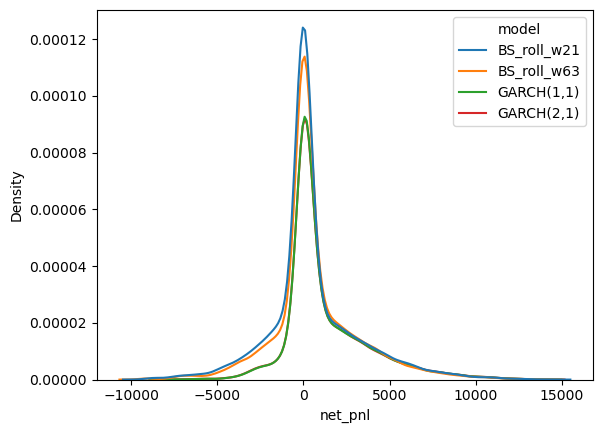

In [71]:
sns.kdeplot(data=df_liveish, x="net_pnl", hue="model")
print(df_liveish.groupby("model")["net_pnl"]
    .agg(["mean", "var", "std", "count"])
    .reset_index())


Now let's take a look at how the net proft & loss changes over time for each ticker. Clearly each ticker results in very different P&L behavior, notably F stays hovering around 0 whereas TSLA, SPY and QQQ have resulted in quite high P&L over time. This visualization suggests that our hedging strategy is capturing the volatility risk premium in highly liquid, option-rich markets, while low-volatility and illiquid tickers don’t provide enough movement to overcome hedging costs

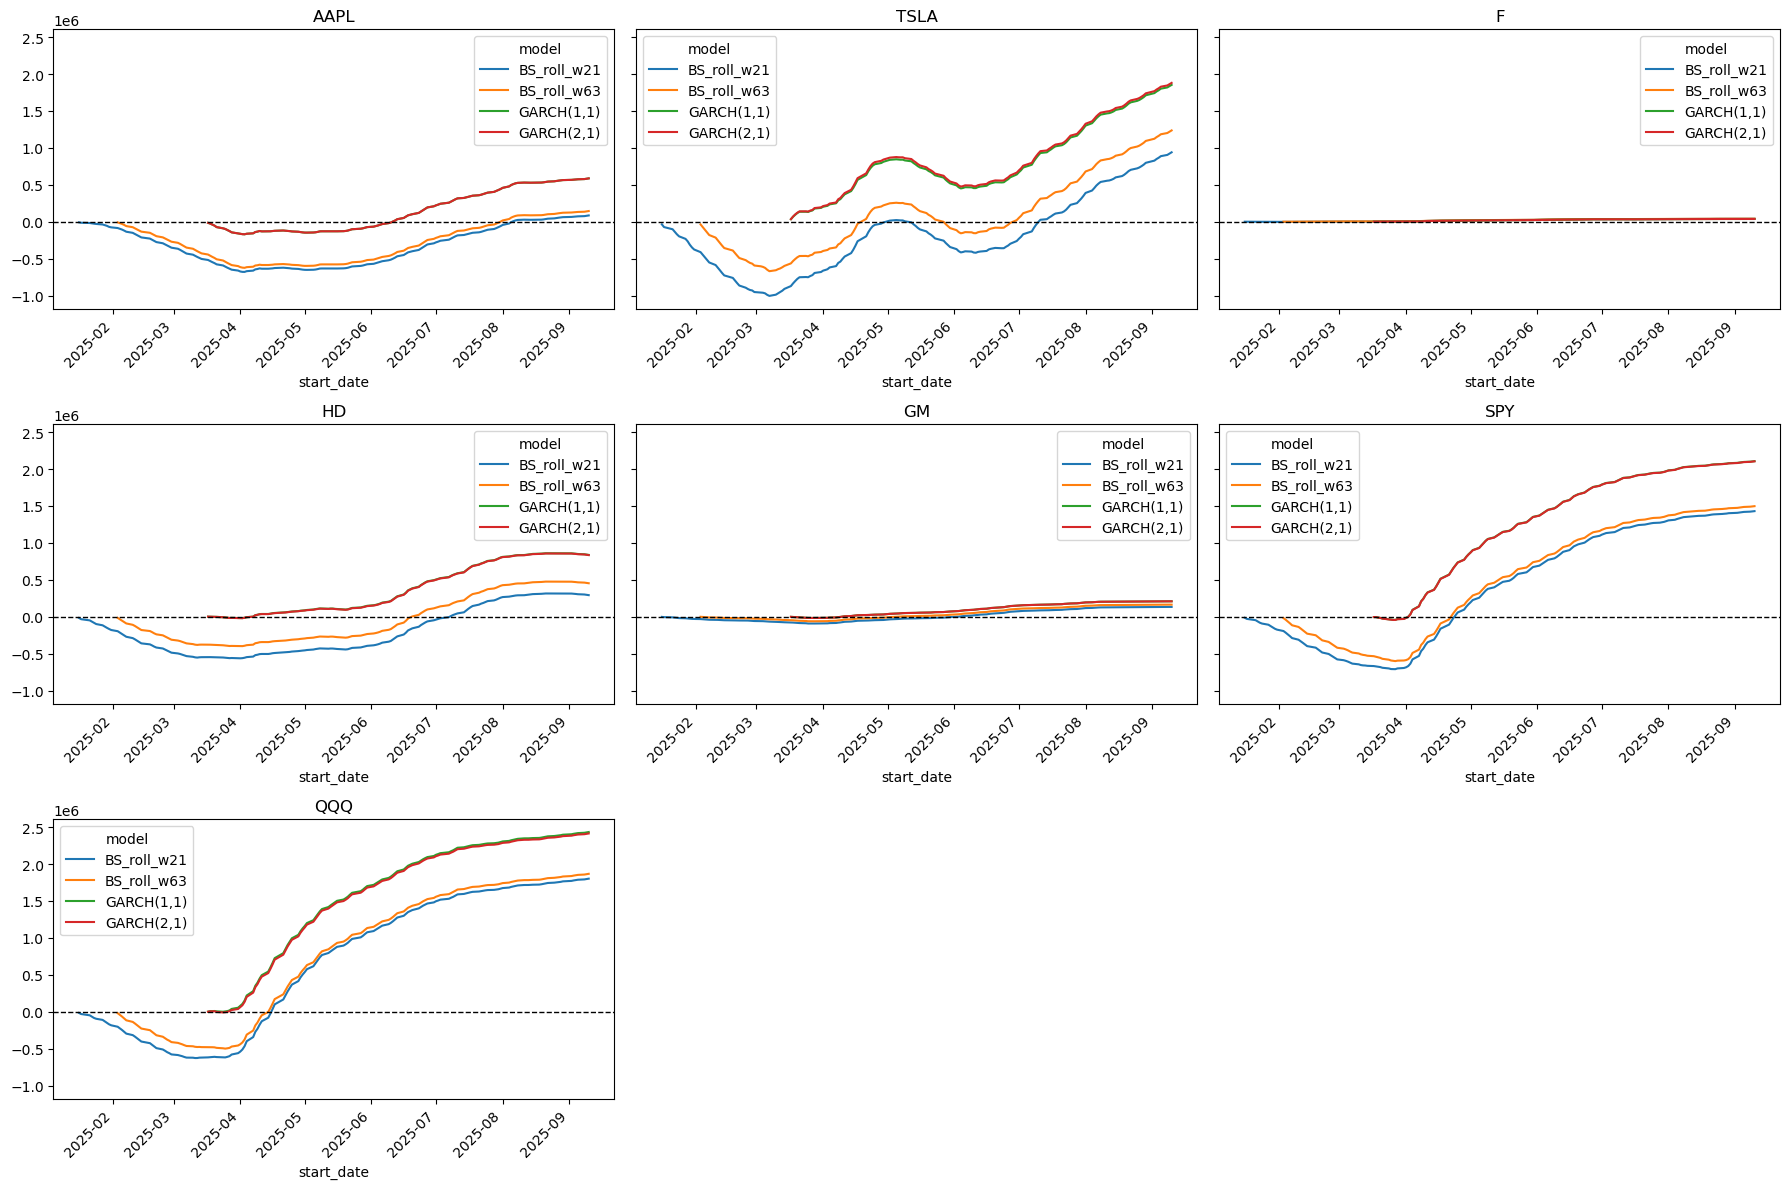

In [72]:
ncols = 3   # 3 plots per row
nrows = -(-len(tickers) // ncols)  # ceiling division

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, 
    figsize=(6*ncols, 4*nrows),   # scale size to grid
    sharey=True
)

axes = axes.flatten()  # make iterable
for ax, tkr in zip(axes, tickers):
    df_tkr = df_liveish[df_liveish.ticker == tkr]
    (
        df_tkr.groupby(["start_date","model"])["net_pnl"]
        .sum()
        .groupby("model")
        .cumsum()
        .unstack()
        .plot(ax=ax)
    )
    ax.set_title(tkr)
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.tick_params(axis='x', rotation=45)

# Hide any unused axes if tickers don't fill grid
for ax in axes[len(tickers):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


Here we have a collection of figures that shows how an option being ITM, ATM or OTM affects the net P&L of each model. It is interesting that all of the figures here are very similar to each other. This indicates that the moneyness and the days to maturity of the option have a larger impact on hedging profitability than the volatility estimation method. ITM options generate wide P&L distributions due to high delta exposure, while OTM options mostly expire worthless and show minimal hedge activity. This highlights that position design can matter more than the choice of volatility model.

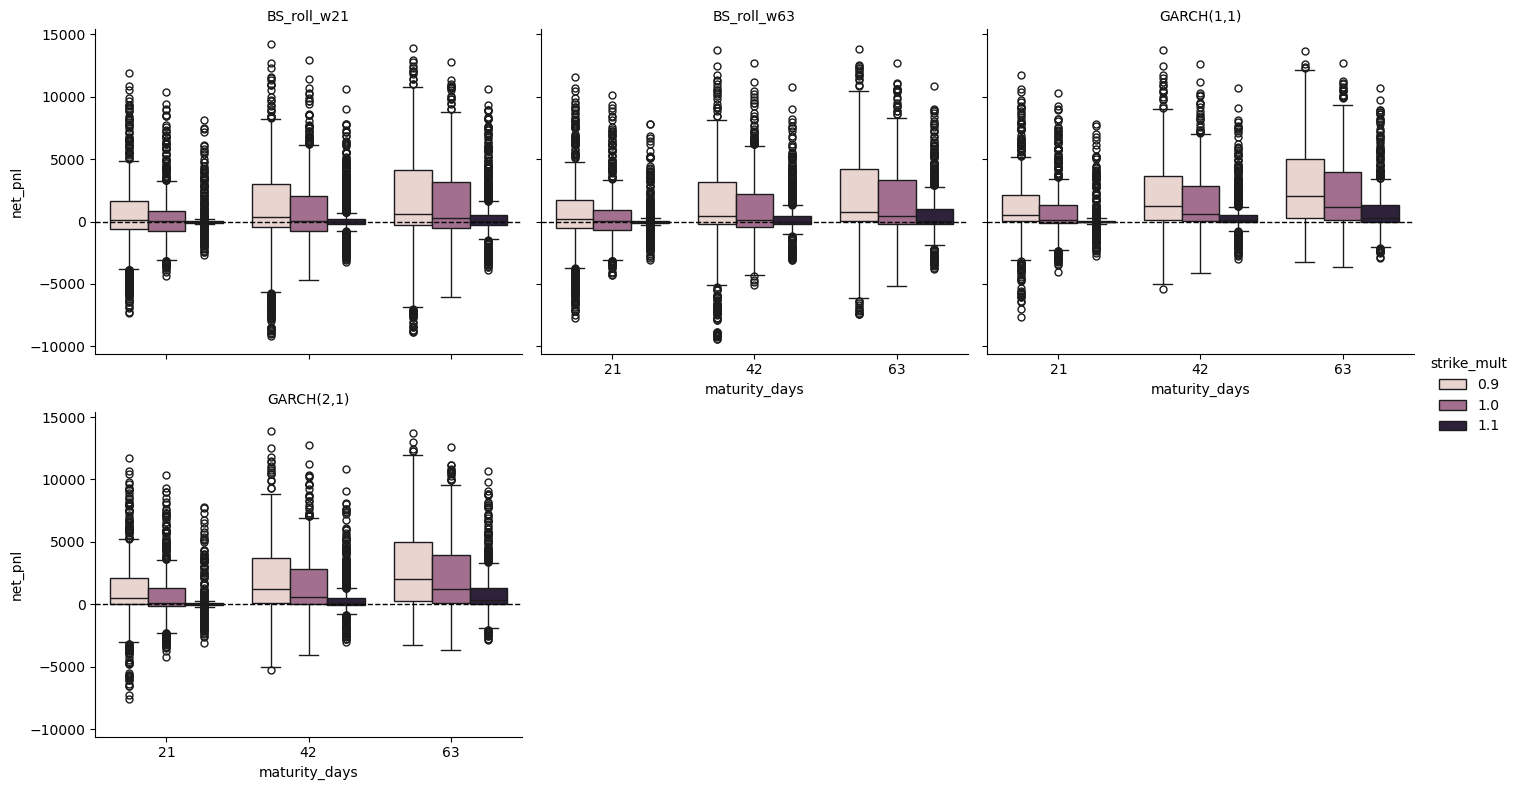

In [73]:
g = sns.catplot(
    data=df_liveish,
    x="maturity_days", y="net_pnl", hue="strike_mult",
    kind="box", col="model", col_wrap=3,
    height=4, aspect=1.2
)
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
plt.show()

Now we can take at the density of the fees as a percentage of the gross P&L. This figure shows that GARCH-based hedging was significantly more fee-efficient, with turnover and costs consistently near zero, unlike Black-Scholes hedges which occasionally suffered high fee drag.

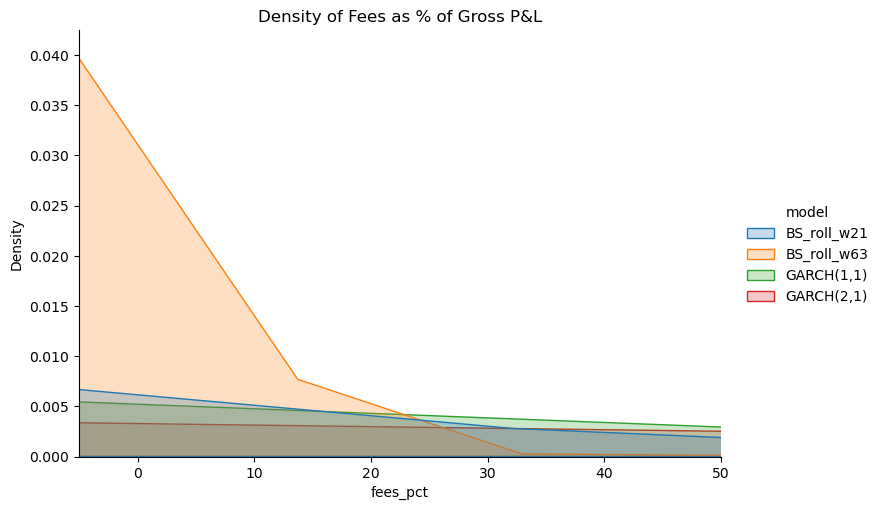

In [80]:
g = sns.displot(
    data=df_liveish, x="fees_pct", hue="model",
    kind="kde", fill=True, common_norm=False,
    height=5, aspect=1.5
)
g.set(xlim=(-5, 50))  # adjust if outliers stretch too far
plt.title("Density of Fees as % of Gross P&L")
plt.show()


How we take a look at the hedging error of each model over time. We define hedging error as the final net asset value - payoff. The figure shows us that all of the models followed a very similar path, though the standard deviation of the hedging error of the GARCH(2, 1) model was consistently smaller than the others. I also find it interesting that the GARCH models were rarely negative and appeared to be finding somewhat of a plateau as time went on.

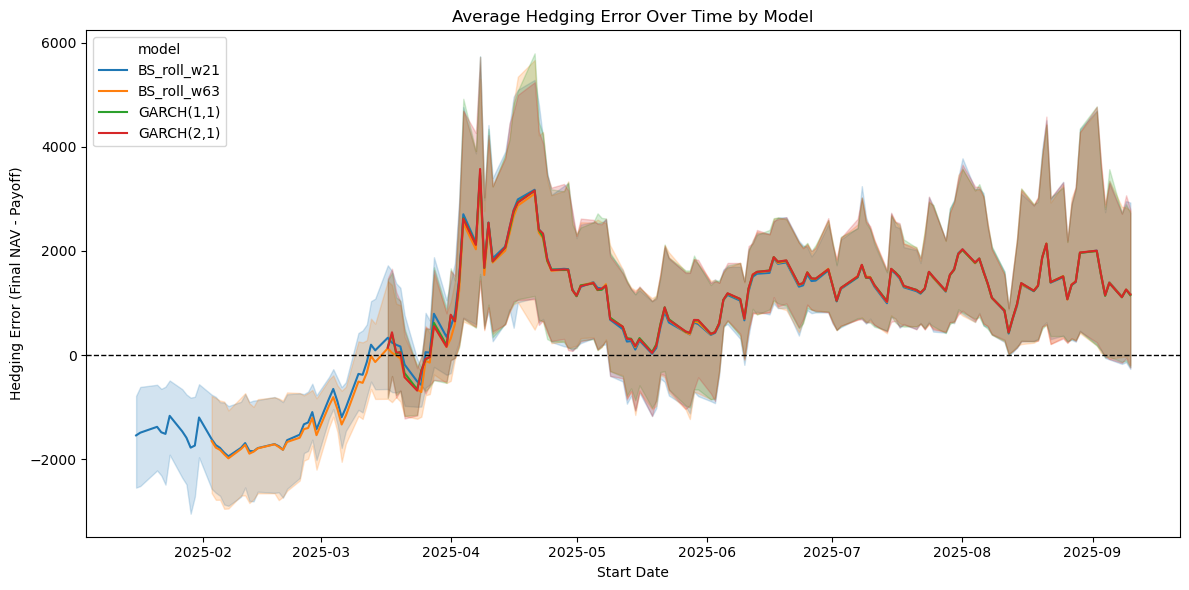

In [75]:
# Compute hedging error per row
df_liveish["hedging_error"] = df_liveish["final_nav"] - df_liveish["payoff"]

# Aggregate by start_date and model (average error across tickers/strikes/maturities)
df_err = (
    df_liveish.groupby(["start_date","ticker","model"])["hedging_error"]
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_err,
    x="start_date",
    y="hedging_error",
    hue="model"
)
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Average Hedging Error Over Time by Model")
plt.ylabel("Hedging Error (Final NAV - Payoff)")
plt.xlabel("Start Date")
plt.tight_layout()
plt.show()


The heatmap below again demonstrates the behavior we were seeing earlier, in that moneyness and maturity are important factors for whether net P&L is close to 0 or not. Long maturity ITM call options tend to provide higher average P&L across the models, whereas short maturity OTM call options result in lower average P&L. This behavior is of course to be expected, so consider this heatmap something of a sanity check. 

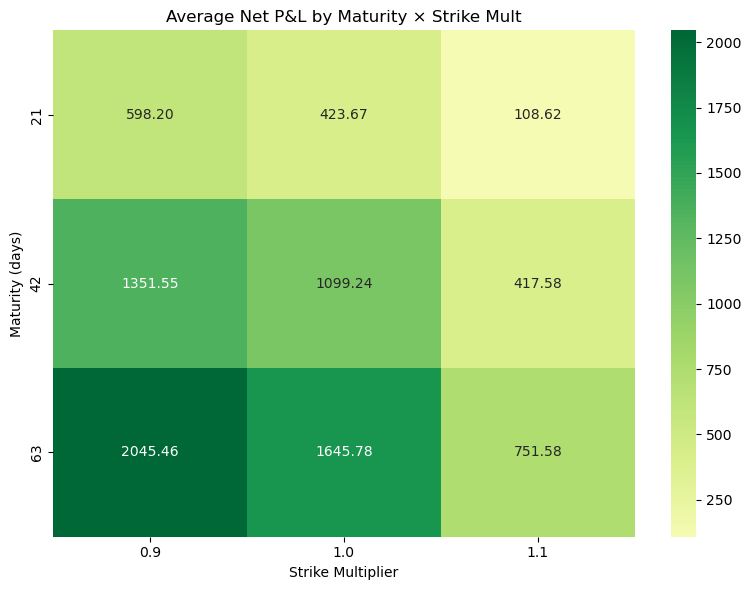

In [76]:
# Compute average net P&L grouped by maturity_days and strike_mult
heatmap_data = (
    df_liveish.groupby(["maturity_days","strike_mult"])["net_pnl"]
    .mean()
    .unstack()   # makes strike_mult the columns
)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    heatmap_data,
    annot=True, fmt=".2f", cmap="RdYlGn", center=0
)
plt.title("Average Net P&L by Maturity × Strike Mult")
plt.xlabel("Strike Multiplier")
plt.ylabel("Maturity (days)")
plt.tight_layout()
plt.show()


The histogram of hedging errors below again shows that all of the models behaved rather similarly, though the GARCH models have higher density concentrations around 0, making them slightly better predictors.

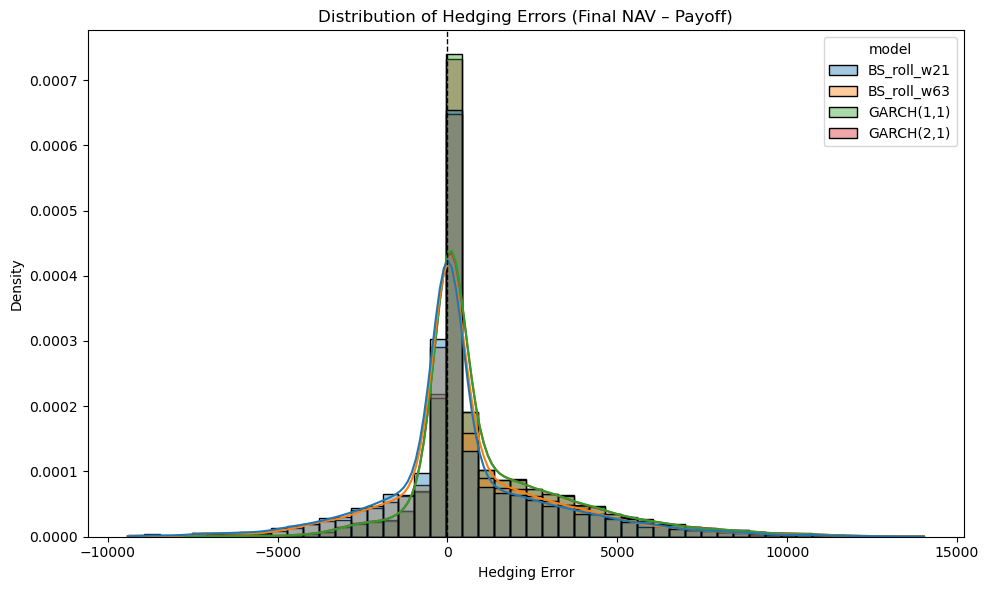

In [77]:
df_liveish["hedging_error"] = df_liveish["final_nav"] - df_liveish["payoff"]

# Compute hedging error if not already present
df_liveish["hedging_error"] = df_liveish["final_nav"] - df_liveish["payoff"]

plt.figure(figsize=(10,6))
sns.histplot(
    data=df_liveish,
    x="hedging_error",
    hue="model",       # BS vs GARCH
    kde=True,          # smooth density estimate
    stat="density",    # normalize for comparability
    common_norm=False, # each model normalized separately
    bins=50,
    alpha=0.4
)

plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.title("Distribution of Hedging Errors (Final NAV – Payoff)")
plt.xlabel("Hedging Error")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


The histogram of turnovers is a little bit more interesting. Here we see that 200 was a popular amount of shares to trade. This likely comes from cases when one contract (100 shares) were bought to hedge, and then sold again later to unwind the hedge, resulting in 200 total shares being traded. Again we see the models all exhibiting similar behavior. The main piece of information that sticks out to me is that BS_roll_w21 is a bit more hesitant to hedge, considering its higher spire at x = 0. This helps to explain why its fees were much smaller than BS_roll_w63's in a previous figure.

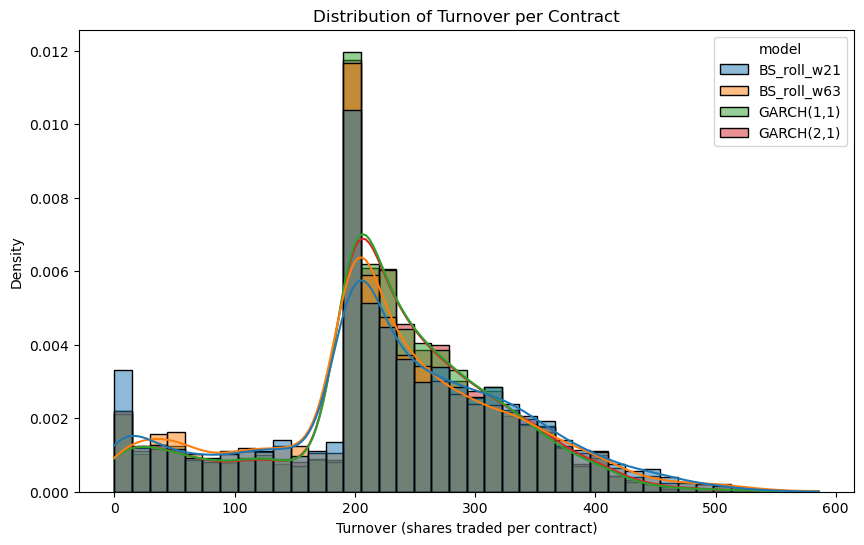

In [78]:
plt.figure(figsize=(10,6))
sns.histplot(
    data=df_liveish,
    x="turnover", hue="model",
    kde=True, stat="density", common_norm=False,
    bins=40, alpha=0.5
)
plt.title("Distribution of Turnover per Contract")
plt.xlabel("Turnover (shares traded per contract)")
plt.ylabel("Density")
plt.show()